In [1]:
import numpy as np
from scipy import misc 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt 
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter 
from pandas import DataFrame 
from time import time

In [2]:
%matplotlib notebook

In [3]:
def U(x, t): return x*t + np.exp(-(3.0*np.pi*0.5)**2*t)*np.sin(3.0*np.pi*x*0.5)

In [4]:
def U_t(x, t): return misc.derivative(lambda s: U(x, s), t, 1e-6, n=1, args=(), order=5)

In [5]:
def U_xx(x, t): return misc.derivative(lambda s: U(s, t), x, dx=1e-6, n=2, args=(), order=5)

In [6]:
def f(x, t): return x

In [7]:
def f_t(x, t): return 0 

In [8]:
def f_xx(x, t): return 0

In [9]:
def w(t, a, alph): return t+np.exp(-(3.0*np.pi*0.5)**2*t)*3.0*np.pi*0.5

In [10]:
def r(t, b): return t

In [11]:
#Binomial coefficient
def Perm(n, k):
    if k == 0: return 1
    elif k > n: return 0
    else: return Perm(n - 1, k) + Perm(n - 1, k - 1)

In [13]:
#Zeroing A[0][p]- element
#IN: A - matrix, b-vector, p-index
#OUT: A-matrix, b-vector
def del_p(A, b, p):
    b[0] -= b[p-1]*A[0][p]/A[p-1][p]
    A[0] = [A[0][j] - A[0][p]*A[p-1][j]/A[p-1][p] for j in range(p+1)]+[0.0 for j in range(p+1, len(A[0]))]
    return A, b

In [14]:
#Bringing A-matrix with long upper boundary condition to tridiagonal form
#IN: A-matrix, b-vector, p-index of last elem in A[0]
#OUT: A-matrix, b-vector
def toTri(A, b, p):
    if p <= 1: return A, b
    else:
        A, b = del_p(A, b, p)
        return toTri(A, b, p-1)

In [15]:
#TriDiagonalMatrixAlgorithm(for matrix with long boundary condition)
#IN: A-matrix, B-vector, p1-index of last non-0 elem in A[0], p2-index of first non-0 elem in A[len(A)-1]
#OUT: X-vector
def TDMA(A, B, p1, p2):
    A, B = toTri(A, B, p1)
    A, B = toTri(np.rot90(A, 2), np.flip(B, 0), p2)
    A, B = np.rot90(A, 2), np.flip(B, 0)
    
    KSI = [0]
    ETA = [0]

    for i in range(len(A)):
        if(i == 0):
            ksi = -A[i][i+1]/A[i][i]
            eta = (B[i])/(A[i][i])
            KSI.append(ksi)
            ETA.append(eta)
        elif(i == len(A)-1):
            ksi = 0
            eta = (B[i] - A[i][i-1]*ETA[i])/(A[i][i-1]*KSI[i] + A[i][i])
            KSI.append(ksi)
            ETA.append(eta)
        else:
            ksi = -A[i][i+1]/(A[i][i-1]*KSI[i] + A[i][i])
            eta = (B[i] - A[i][i-1]*ETA[i])/(A[i][i-1]*KSI[i] + A[i][i])
            KSI.append(ksi)
            ETA.append(eta)
        
    X = [ETA[len(A)]]

    for i in range(len(B)-1, -1, -1):
        x = KSI[i+1]*X[0] + ETA[i+1]
        X.insert(0, x)

    X.pop()
    return X

In [16]:
#SolveHeatEquation
#IN: [a, b]-X_interval, [t0,T]-TIME_interval; N, M-nums of splits of X/TIME; alph-parametr, 
#p1, p2-approximation order of up/down bcon;, sigma-parametr, g_ap-aproximation approach for right part(0 or 1 or 2)
#OUT: Us-solution of HE, x_nod-X_nodes, t_nod-TIME_nodes
def SHE(a, b, t0, T, N, M, alph, p1, p2, sigma, g_ap):
    x_nod = np.linspace(a, b, N+1)
    t_nod = np.linspace(t0, T, M+1)
    h, tau = (b-a)/N, (T-t0)/M
    COEF = np.zeros((N+1, N+1))
    Us = np.zeros((M+1, N+1))
    A, bm = np.zeros((N+1, N+1)), np.zeros(N+1)
    if sigma == 0.5-h**2/(12*tau):
        try: g = { 
            0: lambda x, t: f(x, t) + tau*0.5*f_t(x, t) + (h**2/12)*f_xx(x, t), 
            1: lambda x, t: 0.5*(f(x, t+tau) + f(x, t)) + (f(x-h, t)-2*f(x, t)+f(x+h,t))/12, 
            2: lambda x, t: f(x, t+tau*0.5) + (f(x-h, t+tau*0.5)-2*f(x, t+tau*0.5)+f(x+h,t+tau*0.5))/12
        }[g_ap]
        except KeyError as e:
            g = lambda x, t: f(x, t)
    else:
        g = lambda x, t: f(x, t)
    C = [0.0] + [(-1)**(m+1)*Perm(p1, m)/m for m in range(1, p1+1)]
    B = [0.0] + [(-1)**(m+2)*Perm(p2, m)/m for m in range(1, p2+1)]
    B[0], C[0] = -sum(B), -sum(C)
    COEF[0] = [1.0 - C[0]/(alph*h)] + [float(C[m]/(alph*h)) for m in range(1, p1+1)] + [0.0 for j in range(p1+1, N+1)]
    COEF[N] = [0.0 for j in range(N-p2)] + list(map(lambda x: float(x/h), B))[::-1] 
    for j in range(1, N): COEF[j][j-1], COEF[j][j], COEF[j][j+1] = sigma, (-(h**2/tau)-2*sigma), sigma
    Us[0] = [U(x_i, 0) for x_i in x_nod]
    for n in range(M):
        A, bm[0], bm[N] = np.copy(COEF), w(t_nod[n+1], a, alph), r(t_nod[n+1], b) 
        for j in range(1, N):
            bm[j] = ((sigma-1)*Us[n][j+1] + (2*(1-sigma)-(h**2/tau))*Us[n][j] + (sigma-1)*Us[n][j-1] - h**2*g(x_nod[j], t_nod[n]))
        Us[n+1] = TDMA(A, bm, p1, p2)
    return Us, x_nod, t_nod

In [17]:
#Plotting GRAPHS
def SHOW_G(a, b, t0, T, N, M, alph, p1, p2, sigma, g_ap, flag=0):
    if flag: sigma = 0.5-((b-a)/N)**2/(12*((T-t0)/M))
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    tm = time()
    Us, Xnodes, Tnodes = SHE(a, b, t0, T, N, M, alph, p1, p2, sigma, g_ap)
    Xnodes, Tnodes = np.meshgrid(Xnodes, Tnodes) 
    surf = ax.plot_surface(Xnodes, Tnodes, Us, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    
    ax = fig.add_subplot(1, 2, 2, projection='3d') 
    Ur = U(Xnodes, Tnodes)
    Xnodes, Tnodes = np.meshgrid(np.linspace(a, b, 101), np.linspace(t0, T, 101))
    surf = ax.plot_surface(Xnodes, Tnodes, U(Xnodes, Tnodes), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    
    print("Variance: ", np.amax(np.absolute(Us-Ur)))
    print("RunTime: ", time() - tm)
    plt.show()

In [18]:
#Play TABLE(from N, M to N_jump**it*N, M_jump**it*M)
def SHOW_T(a, b, t0, T, N, M, N_jump, M_jump, it, alph, p1, p2, sigma, g_ap, flag=0):
    if flag: sigma = 0.5-((b-a)/N)**2/(12*((T-t0)/M))
    tm, dataset = time(), []
    for i in range(it):
        if flag: sigma = 0.5-((b-a)/((N_jump)**(i)*N))**2/(12*((T-t0)/((M_jump)**(i)*M)))
        Xnodes, Tnodes = np.meshgrid(np.linspace(a, b, (N_jump)**(i)*N+1), np.linspace(t0, T, (M_jump)**(i)*M+1))
        dataset.append(np.amax(np.absolute(
            SHE(a, b, t0, T, (N_jump)**(i)*N, (M_jump)**(i)*M, alph, p1, p2, sigma, g_ap)[0]-U(Xnodes, Tnodes)
        )))
    print(DataFrame(np.array(dataset), 
                       index=["N="+str((N_jump)**(i)*N)+";M="+str((M_jump)**(i)*M) for i in range(it)], 
                    columns=["Variance"]
                      ))
    print("\nRunTime: ", time()-tm)

In [19]:
SHOW_T(0, 1, 0, 1, 4, 3, 2, 4, 7, 1, 2, 2, 0.7, 1)

               Variance
N=4;M=3        0.126467
N=8;M=12       0.043558
N=16;M=48      0.028192
N=32;M=192     0.008527
N=64;M=768     0.002242
N=128;M=3072   0.000569
N=256;M=12288  0.000143

RunTime:  35.63303804397583


In [30]:
SHOW_T(0, 1, 0, 1, 4, 3, 2, 4, 7, 1, 4, 4, 0.7, 1, 1)

                   Variance
N=4;M=3        9.167968e-01
N=8;M=12       1.176373e-01
N=16;M=48      6.565955e-03
N=32;M=192     4.060881e-04
N=64;M=768     2.547893e-05
N=128;M=3072   1.596100e-06
N=256;M=12288  9.985020e-08

RunTime:  46.5726637840271


<IPython.core.display.Javascript object>


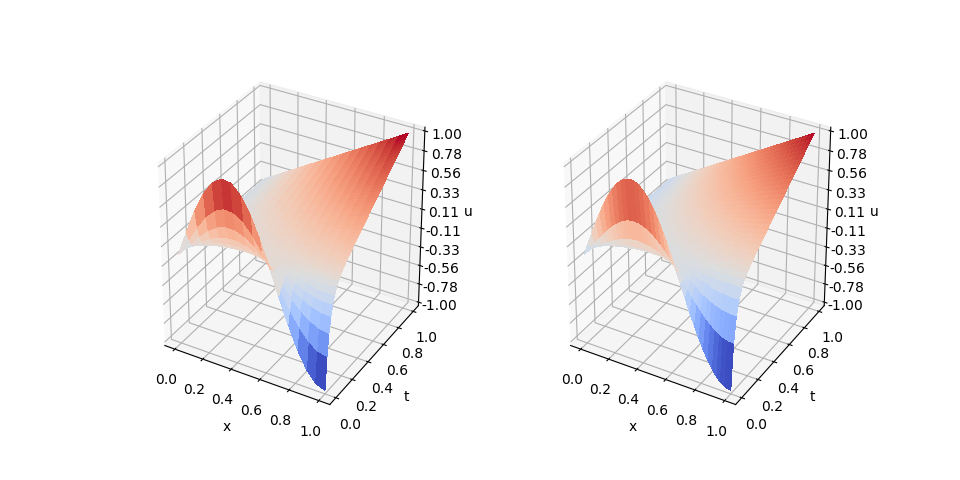

Variance:  0.0281924888732
RunTime:  0.17901039123535156


In [31]:
SHOW_G(0, 1, 0, 1, 16, 48, 1, 2, 2, 0.7, 1)

#### Example1 
$0\leq x \leq 1 ,\, 0\leq t \leq 1\ ;$
```
U(x, t): x*t + np.exp(-(3.0*np.pi*0.5)**2*t)*np.sin(3.0*np.pi*x*0.5)
f(x, t): x
w(x, t): t+np.exp(-(3.0*np.pi*0.5)**2*t)*3.0*np.pi*0.5
r(x, t): t
```

#### Example2
$0\leq x \leq 1 ,\, 0\leq t \leq 1\ ;$
```
U(x, t): np.exp(-4.0*np.pi**2*t)*np.sin(2.0*np.pi*x) - np.exp(-25.0*np.pi**2*t)*np.sin(5.0*np.pi*x)
f(x, t): 0
w(x, t, alph): -(2.0*np.pi*np.exp(-4.0*np.pi**2*t) - 5.0*np.pi*np.exp(-25.0*np.pi**2*t))/alph
r(x, t): 2.0*np.pi*np.exp(-4.0*np.pi**2*t) + 5.0*np.pi*np.exp(-25.0*np.pi**2*t)
```

#### Example3
$-\pi\leq x\leq \pi ,\, 0\leq t\leq 1 ;$
```
U(x, t): np.sin(x+t)
f(x, t): 0
w(x, t, alph): np.sin(t-np.pi) - np.cos(t-np.pi)/alph
r(x, t): np.cos(t+np.pi)
```

#### General Case:
```python
from scipy import misc

def U(x, t): return %input%
def U_t(x, t): return misc.derivative(lambda s: U(x, s), t, 1e-6, n=1, args=(), order=5)
def U_xx(x, t): return misc.derivative(lambda s: U(s, t), x, dx=1e-6, n=2, args=(), order=5)
def f(x, t): return U_t(x, t)-U_xx(x, t)
def f_t(x, t): return misc.derivative(lambda s: f(x, s), t, dx=1e-6, n=1, args=(), order=5)
def f_xx(x, t): return misc.derivative(lambda s: f(s, t), x, dx=1e-6, n=2, args=(), order=5)
def w(t, a, alph): return U(a, t)-(misc.derivative(lambda s: U(s, t), a, dx=1e-6, n=1, args=(), order=5)/alph)
def r(t, b): return misc.derivative(lambda s: U(s, t), b, dx=1e-6, n=1, args=(), order=5)
```